In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from collections import Counter, defaultdict

In [3]:
data = pd.read_csv('./data/after_clean.csv', encoding='gb18030')

In [4]:
customer_freq = data.groupby('AlipayAccount').agg({'OrderID':'count'}).sort_values('OrderID', ascending = False)
customer_freq.shape

(114188, 1)

In [5]:
data.shape

(139771, 30)

We have 139771 records, 114188 customers.  
useful features: OwnedAmount, DeliveryFee, PointsPay, Total, PointsEarned, DirectPay, PointsPay.1, OrderStatus(0-closed, 1-success), BuyerMessage(0-No, 1-Yes), DeliverMethod(?), 

In [6]:
data.head(2)

,OrderID,MemberName,AlipayAccount,OwnedAmount,DeliveryFee,PointsPay,Total,PointsEarned,DirectPay,PointsPay.1,OrderStatus,BuyerMessage,ReceiverName,ReceivingAdd,DeliverMethod,CellPhone,OrderTime,PaytTime,ItemName,ItemCate,DeliverCompany,OrderNote,OrderItemNo,DeliveredTime,StoreReceived,CunTaoOrder,Province,City,OrderToPay(s),PayToReceive(h)
0,"=""561099105503109255""",雷霆3战机,342239175@qq.com,154.84,0.0,0.0,154.84,77.0,154.84,0.0,交易成功,No,陈丹,福建省 福州市 仓山区 东升街道东园路10号金辉莱茵城14号楼（东辉社区）(000000),快递,'13405907147,2019-07-31 23:28:46,2019-07-31 23:28:58,迪宝乐电子积木儿童益智拼装电路玩具男女孩物理教科书5-6-12岁,1.0,韵达快递,No,1.0,2019-08-09 22:38:05,154.84元,否,福建省,福州市,12.0,215.0
1,"=""561103267468252376""",konglingsheng888,kls666@sina.com,109.00,0.0,0.0,109.00,54.0,109.00,0.0,交易成功,No,孔令晟,安徽省 铜陵市 铜官山区 铜官山区虚镇秀水山庄4栋401(244000),快递,'13856271285,2019-07-31 22:58:03,2019-07-31 22:58:30,迪士尼书包小学生男1-3-4年级汽车麦昆卡通儿童护脊双肩背包,1.0,圆通速递,No,1.0,2019-08-03 19:47:38,109.00元,否,安徽省,铜陵市,27.0,68.0


In [7]:
data['StoreReceived'] = data['StoreReceived'].apply(lambda x:float(x[:-1]))

In [8]:
data['OrderTime'] = data['OrderTime'].apply(lambda x:pd.to_datetime(x))
data['PaytTime'] = data['PaytTime'].apply(lambda x:pd.to_datetime(x))

In [9]:
data['DaysToAug'] = data['OrderTime'].apply(lambda x:\
            int(str(pd.to_datetime('2019-08-01 00:00:00') - x).split(' ')[0]) + 1)

In [10]:
customer_freq.head(10)

,OrderID
AlipayAccount,
13143505932,61
996038333@qq.com,49
17712515083,40
financetba-th@lazada.com,35
995252337@qq.com,26
13488112766,20
williamk01@qq.com,18
kaensmile@sohu.com,17
tangwell@126.com,16


In [11]:
def interval_two_orders(df, accounts):
    '''
    Calculate and plot the distribution of interval between two orders of one customer
    df: the dataframe contains records of all orders
    accounts: list of customer accounts 
    '''
    for account in accounts:
        tmp = df[df['AlipayAccount'] == account][['AlipayAccount','DaysToAug']]
        interval = np.array(tmp.DaysToAug)[1:] - np.array(tmp.DaysToAug)[:-1]
        
        interval_days = Counter(interval)
        interval_days_df = pd.DataFrame({'interval_days':list(interval_days.keys()),\
                                         'count':list(interval_days.values())}).sort_values('interval_days').\
                                          set_index('interval_days')
                                         
        interval_days_df.plot(kind = 'bar', rot=0)
        plt.yticks(np.arange(0, max(interval_days_df['count']+1), step=1))
        plt.title(f'interval between two orders of {account}')

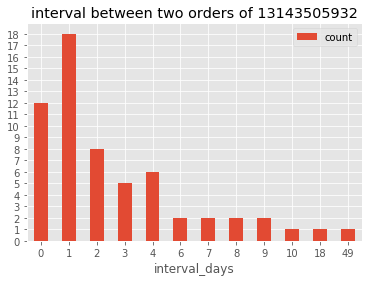

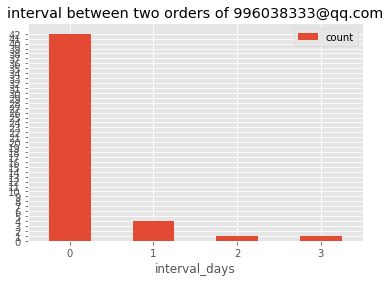

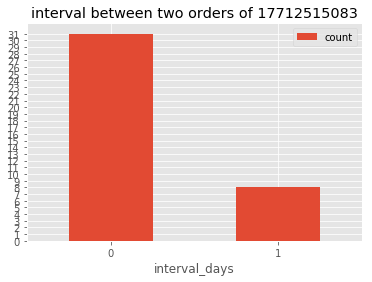

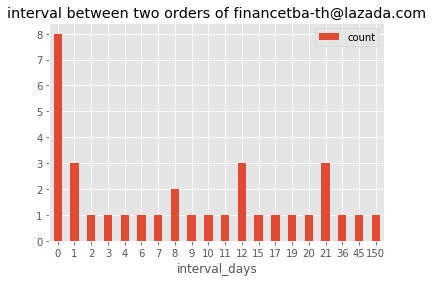

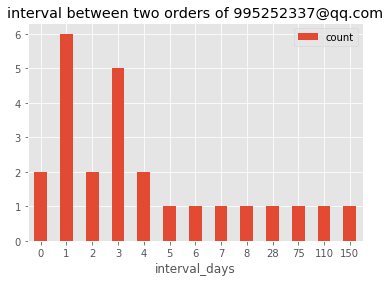

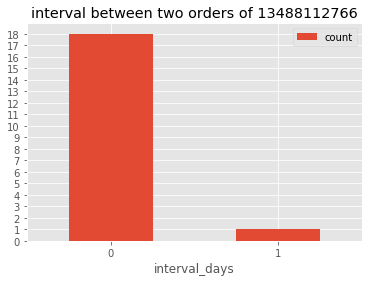

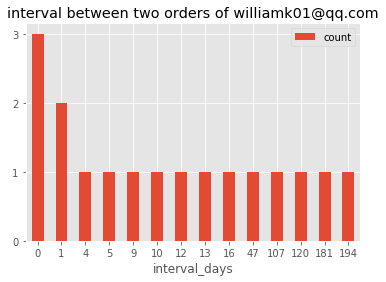

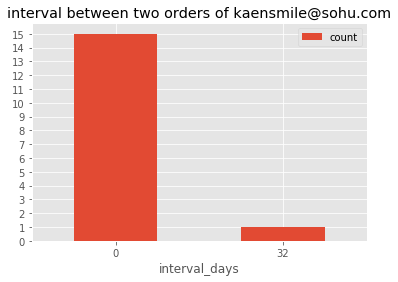

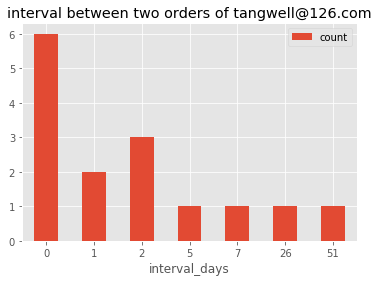

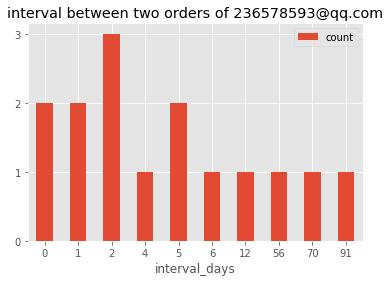

In [12]:
# 购买次数最多的10个用户的intervals
interval_two_orders(data, list(customer_freq.head(10).index))

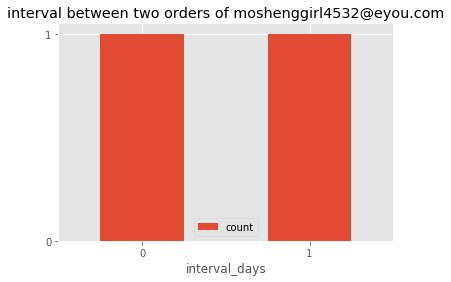

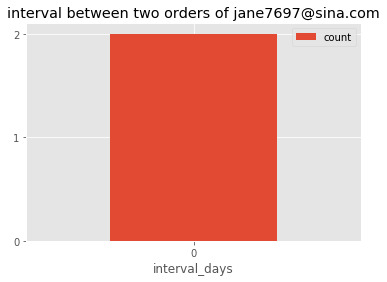

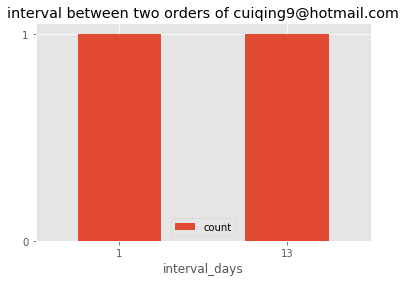

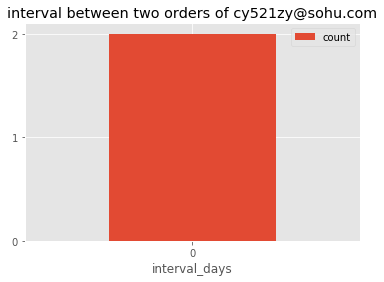

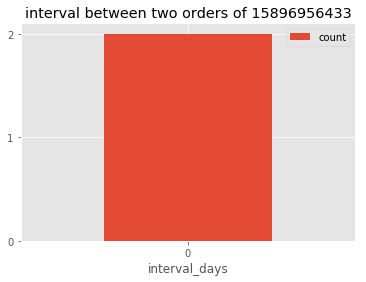

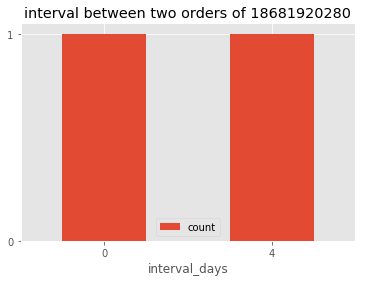

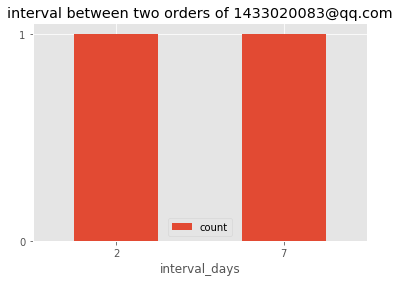

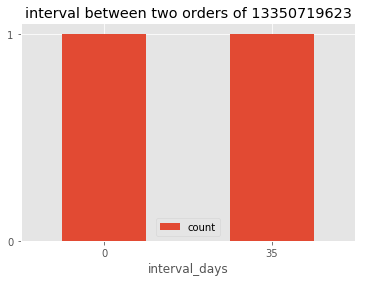

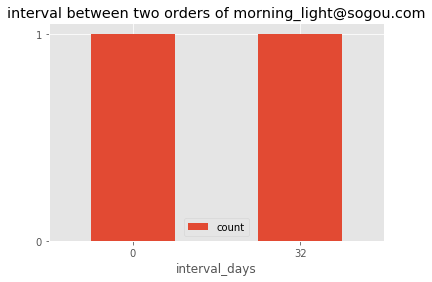

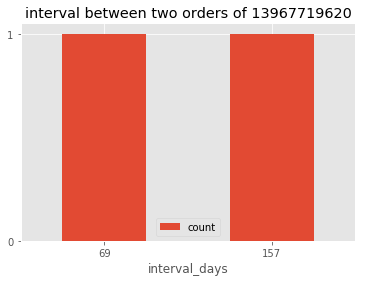

In [13]:
# 购买次数为3的10个用户的intervals
interval_two_orders(data, list(customer_freq[customer_freq['OrderID'] == 3].head(10).index))

In [14]:
# 所有次数大于2的用户的intervals
accounts_2 = list(customer_freq[customer_freq['OrderID'] > 1].index)

In [15]:
test = []
for account in accounts_2:
    tmp = data[data['AlipayAccount'] == account][['AlipayAccount','DaysToAug']]
    interval = np.array(tmp.DaysToAug)[1:] - np.array(tmp.DaysToAug)[:-1]
    test.append(list(interval))
    
test = sum(test,[])

In [16]:
interval_days = Counter(test)
interval_days_df = pd.DataFrame({'interval_days':list(interval_days.keys()),\
                                 'count':list(interval_days.values())}).sort_values('interval_days').\
                                  set_index('interval_days')

In [17]:
interval_days_df.reset_index(inplace=True)

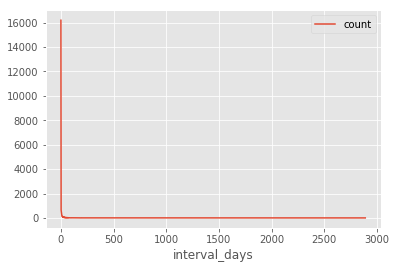

In [18]:
interval_days_df.plot('interval_days', 'count')

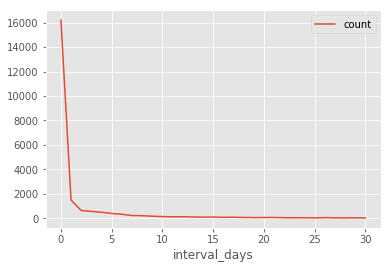

In [19]:
interval_days_df[interval_days_df['interval_days'] < 31].plot('interval_days', 'count')

In [20]:
# Most customers will come back in 30 days.
# 目标是预测一个用户进行购买行为T天后，还会继续购买的概率
# or   预测一个用户进行购买行为T天内，还会继续购买的概率？

In [21]:
def draw_correlation(df, col1, col2):
    df.plot(col1, col2, kind='scatter')
    cor = np.corrcoef(df[col1], df[col2])[0,1]
    print(f'The correlation between {col1} and {col2} is {cor}.')

The correlation between OwnedAmount and Total is 0.9999987322478258.


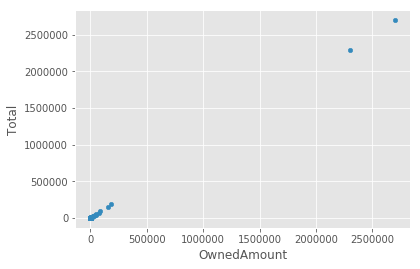

In [22]:
draw_correlation(data, 'OwnedAmount', 'Total')

'OrderID'        : drop  
'MemberName'     : drop  
'AlipayAccount'  : drop
'OwnedAmount'    : highly correlated with Total, DirectPay, 2 outliers, drop(?
'DeliveryFee'    : keep
'PointsPay'      : keep
'Total'          : drop
'PointsEarned'   : keep
'DirectPay'      : drop
'PointsPay.1'    : drop, high correlated with PointsPay
'OrderStatus'    : 1/0
'BuyerMessage'   : drop
'ReceiverName'   : drop
'ReceivingAdd'   : drop
'DeliverMethod'  : dummy
'CellPhone'      : drop
'OrderTime'      : drop
'PaytTime'       : drop
'ItemName'       : drop
'ItemCate'       : drop(??
'DeliverCompany' : drop
'OrderNote'      : drop 这是卖家的备注
'OrderItemNo'    : drop, high correlated with OwnedAmount(????
'DeliveredTime'  : drop
'StoreReceived'  : drop
'CunTaoOrder'    : 1/0
'Province'       : dummy
'City'           : drop
'OrderToPay(s)'  : 暂时drop
'PayToReceive(h)': 暂时drop
'DaysToAug'      : drop

添加列:
    某用户在本次购买之前的购买次数

In [41]:
OrderCount = []
for i in range(data.shape[0]):
    account = data.iloc[i,]['AlipayAccount']
    date = data.iloc[i,]['OrderTime']
    count = data[(data['AlipayAccount'] == account) & (data['OrderTime'] < date)].shape[0]
    OrderCount.append(count)
    
    if i%200 == 0:
        print(i)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000
24200
24400
24600
24800
25000
25200
25400
25600
25800
26000
26200
26400
26600
26800
27000
27200
27400
27600
27800
28000
28200
28400
28600
28800
29000
29200
29400
29600
29800
30000
30200
30400
30600
30800
31000
31200
31400
31600
31800
32000
32200
32400
32600
32800
33000
33200
33400
33600
33800
34000
34200
34400
34600
34800
35000
3

In [43]:
data['OrderCount'] = OrderCount

In [45]:
data['OrderStatus1'] = data['OrderStatus'].apply(lambda x:1 if x == '交易成功' else 0)

In [51]:
data1 = data[data['OrderTime'] < '2019-07-01 00:00:00']

In [53]:
data1.shape

(138995, 33)

In [69]:
ordered_in_30days = []

for i in range(data1.shape[0]):
    orderid = data1.iloc[i,]['OrderID']
    account = data1.iloc[i,]['AlipayAccount']
    date_low = data1.iloc[i,]['OrderTime'] 
    date_up = date_low + pd.DateOffset(30)
    
    data_except = data[data['OrderID'] != orderid]
    orders_in_30days = data_except[(data_except['AlipayAccount']==account) &\
                                   ((data_except['OrderTime']>=date_low)&(data_except['OrderTime']<=date_up))]
    ordered_in_30days.append(orders_in_30days.shape[0])
    
    if i%500 == 0:
        print(i)
    

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

In [72]:
data1['OrderIn30'] = ordered_in_30days

In [75]:
data1['OrderIn30'] = data1['OrderIn30'].apply(lambda x:1 if x > 0 else 0)

In [79]:
data1['CunTaoOrder'] = data1['CunTaoOrder'].apply(lambda x:0 if x == '否' else 1)

In [80]:
data1[data1['AlipayAccount'] == '236578593@qq.com']

,OrderID,MemberName,AlipayAccount,OwnedAmount,DeliveryFee,PointsPay,Total,PointsEarned,DirectPay,PointsPay.1,OrderStatus,BuyerMessage,ReceiverName,ReceivingAdd,DeliverMethod,CellPhone,OrderTime,PaytTime,ItemName,ItemCate,DeliverCompany,OrderNote,OrderItemNo,DeliveredTime,StoreReceived,CunTaoOrder,Province,City,OrderToPay(s),PayToReceive(h),DaysToAug,OrderCount,OrderStatus1,OrderIn30
20023,117210607224793257,破旧的老房子,236578593@qq.com,198.0,0.0,0.0,198.0,99.0,198.0,0.0,交易成功,No,司海青,江苏省 南京市 江宁区 秣陵镇静淮街中航樾府20栋1单元706(000000),快递,'13770317772,2018-02-10 11:47:03,2018-02-10 11:47:18,迪士尼拉杆书包小学生男2-5年级汽车总动员3麦昆儿童4三轮拉杆包,1.0,圆通速递,No,1.0,2018-03-14 09:00:24,198.0,0,江苏省,南京市,15.0,765.0,537,15,1,0
26447,88066724531793257,破旧的老房子,236578593@qq.com,182.0,0.0,0.0,182.0,91.0,182.0,0.0,交易成功,发圆通,邰振,江苏省 苏州市 姑苏区 金阊区虎丘路观景新村11-504(000000),快递,'13915523845,2017-11-11 00:37:02,2017-11-11 00:37:14,【双11狂欢价】迪士尼小学生书包1-3年级男夜光防水小孩两用三轮爬楼梯拉杆背包,1.0,韵达快递,No,1.0,2017-11-26 08:53:40,182.0,0,江苏省,苏州市,12.0,368.0,628,14,1,0
29878,54089898300793257,破旧的老房子,236578593@qq.com,188.0,0.0,0.0,188.0,94.0,188.0,0.0,交易成功,发韵达,宋娟,江苏省 南京市 栖霞区 栖霞区城区朗诗钟山绿郡2栋506-紫东路9号(000000),快递,'13814006868,2017-09-02 00:35:51,2017-09-02 00:36:05,迪士尼小学生书包1-3年级男夜光防水小孩两用三轮爬楼梯拉杆背包,1.0,韵达快递,No,1.0,2017-09-12 08:50:08,188.0,0,江苏省,南京市,14.0,248.0,698,13,1,0
30504,52066337779793257,破旧的老房子,236578593@qq.com,198.0,0.0,0.0,198.0,99.0,198.0,0.0,交易成功,发韵达,刘媛媛,内蒙古自治区 通辽市 奈曼旗 尚水御都10号楼新裕安装公司(000000),快递,'13754056838,2017-08-28 17:45:43,2017-08-28 17:45:58,新品迪士尼拉杆书包小学生3-5年级汽车总动员麦昆儿童三轮拉杆包,1.0,韵达快递,'3101397962516韵达,1.0,2017-09-07 23:01:01,198.0,0,内蒙古自治区,通辽市,15.0,245.0,703,12,1,1
31069,51179577254793257,破旧的老房子,236578593@qq.com,208.0,0.0,0.0,208.0,104.0,208.0,0.0,交易成功,No,林丽旋,福建省 泉州市 晋江市 福建省泉州市晋江市陈埭镇坊脚村环村南路47号(000000),快递,'15060933079,2017-08-26 10:56:57,2017-08-26 10:57:16,新品迪士尼拉杆书包小学生3-5年级汽车总动员麦昆儿童三轮拉杆包,1.0,韵达快递,'韵达3101397962521,1.0,2017-09-05 11:30:27,208.0,0,福建省,泉州市,19.0,240.0,705,11,1,1
31636,50493298676793257,破旧的老房子,236578593@qq.com,91.0,0.0,0.0,91.0,45.0,91.0,0.0,交易成功,No,雷显玉,河南省 信阳市 商城县 迎水村上彭湾(465350),快递,'15700159953,2017-08-24 00:05:52,2017-08-24 00:09:15,迪士尼儿童书包小学生男童1-3年级汽车总动员卡通3D减负双肩背包,1.0,韵达快递,No,1.0,2017-09-03 08:23:25,91.0,0,河南省,信阳市,203.0,248.0,707,10,1,1
31734,50337646510793257,破旧的老房子,236578593@qq.com,208.0,0.0,0.0,208.0,104.0,208.0,0.0,交易成功,No,王燕,河南省 信阳市 潢川县 河南省信阳市潢川县亚兴超市门口刘洋发型收(000000),快递,'13253855551,2017-08-23 15:53:31,2017-08-23 15:56:35,新品迪士尼拉杆书包小学生3-5年级汽车总动员麦昆儿童三轮拉杆包,1.0,韵达快递,'韵达3101397962533,1.0,2017-09-04 23:25:21,208.0,1,河南省,信阳市,184.0,295.0,708,9,1,1
33126,46435987555793257,破旧的老房子,236578593@qq.com,208.0,0.0,0.0,208.0,104.0,208.0,0.0,交易成功,No,张建军,广东省 深圳市 宝安区 宝安区州石路九围段宏发创新园广东青泉律师事务所(000000),快递,'13631680942,2017-08-18 09:15:17,2017-08-18 09:33:41,新品迪士尼拉杆书包小学生3-5年级汽车总动员麦昆儿童三轮拉杆包,1.0,韵达快递,No,1.0,2017-08-28 10:42:02,208.0,0,广东省,深圳市,1104.0,241.0,713,8,1,1
33129,46395414253793257,破旧的老房子,236578593@qq.com,208.0,0.0,0.0,208.0,104.0,208.0,0.0,交易成功,No,纪恒,上海 上海市 徐汇区 徐汇区城区凯滨路19弄尚海湾12号802(000000),快递,'15000198662,2017-08-18 09:07:06,2017-08-18 09:33:05,新品迪士尼拉杆书包小学生3-5年级汽车总动员麦昆儿童三轮拉杆包,1.0,韵达快递,No,1.0,2017-08-28 10:42:01,208.0,0,上海,上海市,1559.0,241.0,713,7,1,1
33396,45886203356793257,破旧的老房子,236578593@qq.com,178.0,0.0,0.0,178.0,89.0,178.0,0.0,交易成功,No,刘润香,重庆 重庆市 南川区 重庆南川区南平镇永安村(000000),快递,'13668210651,2017-08-16 21:26:17,2017-08-16 21:26:24,迪士尼小学生书包1-3年级男夜光防水小孩两用三轮爬楼梯拉杆背包,1.0,韵达快递,No,1.0,2017-08-27 08:20:48,178.0,0,重庆,重庆市,7.0,250.0,715,6,1,1


In [81]:
data1 = data1.drop(['OrderID', 'MemberName', 'AlipayAccount', 'Total', 'DirectPay', 'PointsPay.1', 'OrderStatus',\
                  'BuyerMessage', 'ReceiverName', 'ReceivingAdd', 'CellPhone', 'OrderTime', 'PaytTime',\
                  'ItemName', 'ItemCate', 'DeliverCompany', 'OrderNote', 'OrderItemNo', 'DeliveredTime',\
                  'StoreReceived', 'City', 'OrderToPay(s)', 'PayToReceive(h)', 'DaysToAug'], axis =1)

data1.reset_index(drop=True, inplace=True)

In [85]:
data1.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,DeliverMethod,CunTaoOrder,Province,OrderCount,OrderStatus1,OrderIn30
0,183.00,0.0,0.0,91.0,快递,1,浙江省,0,1,0
1,188.00,0.0,0.0,94.0,快递,0,江苏省,0,1,0
2,149.94,0.0,0.0,74.0,快递,0,辽宁省,0,1,0
3,98.00,0.0,0.0,0.0,快递,0,四川省,0,0,0
4,123.00,0.0,0.0,61.0,快递,0,广西壮族自治区,0,1,0


In [88]:
data_final = pd.get_dummies(data1, drop_first=True)

In [91]:
data_final.shape

(138995, 49)

In [89]:
data_final.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,CunTaoOrder,OrderCount,OrderStatus1,OrderIn30,DeliverMethod_卖家承担运费,DeliverMethod_平邮,DeliverMethod_快递,DeliverMethod_虚拟物品,Province_云南省,Province_云浮市,Province_内蒙古自治区,Province_北京,Province_台湾,Province_台湾省,Province_吉林省,Province_吉隆坡,Province_四川省,Province_天津,Province_宁夏回族自治区,Province_安徽省,Province_山东省,Province_山西省,Province_广东省,Province_广西壮族自治区,Province_新疆维吾尔自治区,Province_江苏省,Province_江西省,Province_河北省,Province_河南省,Province_浙江省,Province_海南省,Province_海外,Province_湖北省,Province_湖南省,Province_澳门特别行政区,Province_甘肃省,Province_福建省,Province_西藏自治区,Province_贵州省,Province_辽宁省,Province_重庆,Province_陕西省,Province_青海省,Province_香港特别行政区,Province_黑龙江省
0,183.00,0.0,0.0,91.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,188.00,0.0,0.0,94.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,149.94,0.0,0.0,74.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,98.00,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,123.00,0.0,0.0,61.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [90]:
data_final.to_csv('./data/data_final.csv', encoding='gb18030')

In [94]:
X = data_final.drop('OrderIn30', axis=1)

In [92]:
y = data_final['OrderIn30']

In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [111]:
X_train.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,CunTaoOrder,OrderCount,OrderStatus1,DeliverMethod_卖家承担运费,DeliverMethod_平邮,DeliverMethod_快递,DeliverMethod_虚拟物品,Province_云南省,Province_云浮市,Province_内蒙古自治区,Province_北京,Province_台湾,Province_台湾省,Province_吉林省,Province_吉隆坡,Province_四川省,Province_天津,Province_宁夏回族自治区,Province_安徽省,Province_山东省,Province_山西省,Province_广东省,Province_广西壮族自治区,Province_新疆维吾尔自治区,Province_江苏省,Province_江西省,Province_河北省,Province_河南省,Province_浙江省,Province_海南省,Province_海外,Province_湖北省,Province_湖南省,Province_澳门特别行政区,Province_甘肃省,Province_福建省,Province_西藏自治区,Province_贵州省,Province_辽宁省,Province_重庆,Province_陕西省,Province_青海省,Province_香港特别行政区,Province_黑龙江省
137933,169.0,0.0,0.0,84.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55564,288.0,0.0,0.0,144.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
124578,158.0,30.0,0.0,79.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
66135,188.0,0.0,0.0,94.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6444,149.0,0.0,0.0,74.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [115]:
from sklearn.preprocessing import StandardScaler

standard_features = ['OwnedAmount', 'DeliveryFee', 'PointsPay', 'PointsEarned']
std = StandardScaler()
scaler = std.fit(X_train.loc[:,standard_features])
X_train.loc[:,standard_features] = scaler.transform(X_train.loc[:,standard_features])
X_test.loc[:,standard_features] = scaler.transform(X_test.loc[:,standard_features])

In [116]:
X_train.head()

,OwnedAmount,DeliveryFee,PointsPay,PointsEarned,CunTaoOrder,OrderCount,OrderStatus1,DeliverMethod_卖家承担运费,DeliverMethod_平邮,DeliverMethod_快递,DeliverMethod_虚拟物品,Province_云南省,Province_云浮市,Province_内蒙古自治区,Province_北京,Province_台湾,Province_台湾省,Province_吉林省,Province_吉隆坡,Province_四川省,Province_天津,Province_宁夏回族自治区,Province_安徽省,Province_山东省,Province_山西省,Province_广东省,Province_广西壮族自治区,Province_新疆维吾尔自治区,Province_江苏省,Province_江西省,Province_河北省,Province_河南省,Province_浙江省,Province_海南省,Province_海外,Province_湖北省,Province_湖南省,Province_澳门特别行政区,Province_甘肃省,Province_福建省,Province_西藏自治区,Province_贵州省,Province_辽宁省,Province_重庆,Province_陕西省,Province_青海省,Province_香港特别行政区,Province_黑龙江省
137933,-0.006821,-0.161176,-0.101177,0.122450,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
55564,0.003625,-0.161176,-0.101177,0.772146,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
124578,-0.007786,1.793762,-0.101177,0.068309,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
66135,-0.005153,-0.161176,-0.101177,0.230733,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6444,-0.008576,-0.161176,-0.101177,0.014168,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [118]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


grid = {"C":np.logspace(-3,3,7), 
        "penalty":["l1","l2"]
       }

logit = LogisticRegression()
logit_cv=GridSearchCV(logit, grid, cv=10)
logit_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logit_cv.best_params_)
print("accuracy :",logit_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1'}
accuracy : 0.8535294359480349


In [120]:
logit_best = LogisticRegression(penalty='l1', C=0.01)
logit_best.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [153]:
y_pred = logit_best.predict(X_train)

In [154]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred)

array([[78731,  2930],
       [11318,  4317]])

In [155]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 4317
True Negative: 78731
False Positive: 2930
False Negative: 11318


In [156]:
tp/(tp + fn)

0.27611128877518387

In [ ]:
其实买了 但是预测为没买的很多
意味着失去了很多潜在客户（流失率增加）

除了考虑用户是否流失外，还应当考虑该用户的流失概率.流失概率越大的优先对其采取优惠措施

In [ ]:
### Set cutoff??

In [130]:
y_pred_proba = logit_best.predict_proba(X_train)

In [131]:
y_pred_proba

array([[0.92463121, 0.07536879],
       [0.94397429, 0.05602571],
       [0.94383958, 0.05616042],
       ...,
       [0.44591945, 0.55408055],
       [0.9245466 , 0.0754534 ],
       [0.9441438 , 0.0558562 ]])

In [165]:
from sklearn import metrics

accuracy_ls = []
for thres in np.arange(0,1.1,0.1):
    y_pred = np.where(y_pred_proba[:,0]<thres,1,0)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    recall = tp/(tp + fn)
    acc = (tp + tn)/(tp+tn+fp+fn)
    
    print(f'threshold is {thres}')
    print(confusion_matrix(y_train, y_pred))
    print(f'recall is {recall}')
    print(f'accuracy is {acc}')
    print('-'*50)

threshold is 0.0
[[81661     0]
 [15635     0]]
recall is 0.0
accuracy is 0.8393048018418023
--------------------------------------------------
threshold is 0.1
[[81636    25]
 [15508   127]]
recall is 0.008122801407099456
accuracy is 0.8403531491530998
--------------------------------------------------
threshold is 0.2
[[81597    64]
 [15410   225]]
recall is 0.014390789894467541
accuracy is 0.8409595461272817
--------------------------------------------------
threshold is 0.30000000000000004
[[81479   182]
 [15179   456]]
recall is 0.029165334186120884
accuracy is 0.8421209505015622
--------------------------------------------------
threshold is 0.4
[[81177   484]
 [14515  1120]]
recall is 0.07163415414134953
accuracy is 0.8458415556651866
--------------------------------------------------
threshold is 0.5
[[78731  2930]
 [11318  4317]]
recall is 0.27611128877518387
accuracy is 0.8535602696924848
--------------------------------------------------
threshold is 0.6000000000000001
[[701